In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

import openai
import os
import json
from datetime import datetime
from langchain.llms import OpenAI

In [ ]:
!pip install -r '/content/requirements.txt'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.8/120.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
img = image.load_img('/content/drive/MyDrive/train2/16-20/16_1371.jpeg')


# New Section

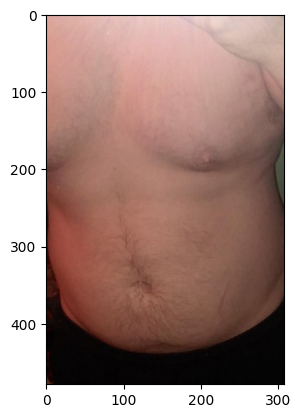

In [ ]:
plt.imshow(img)

In [ ]:
#data augmentation
train = ImageDataGenerator(brightness_range=[0.9,1.1],
                           zoom_range=1.1,
                           rescale=1./255)
validate = ImageDataGenerator(rescale=1./255)

In [ ]:
!chmod +x /content/drive/MyDrive/ColabNotebooks1/remove_checkpoints.sh
!/content/drive/MyDrive/ColabNotebooks1/remove_checkpoints.sh


In [ ]:
# Creating the dataset generators
train_dataset = train.flow_from_directory('/content/drive/MyDrive/train2',
                                          target_size=(240, 240), batch_size=32,
                                          class_mode='categorical')
validation_dataset = validate.flow_from_directory('/content/drive/MyDrive/validate',
                                                  target_size=(240, 240), batch_size=32,
                                                  class_mode='categorical')



Found 1300 images belonging to 3 classes.
Found 379 images belonging to 3 classes.


In [ ]:
train_dataset.class_indices


{'16-20': 0, '20+': 1, '6-15': 2}

In [ ]:
#outer layer dimensions to 3 as 3 channels(R,G,B), activation function as softmax for categorical X-entropy
def create_efficientnet_model(input_shape=(240, 240, 3), num_classes=3):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = True  # Unfreeze the model up to the last block

    # Freeze all layers except the last 10 layers
    #for layer in base_model.layers[:-10]:
        #layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [ ]:
def predict_body_fat(val):

    # Calculate the predicted body fat percentage
    predicted_bf = (val[0][1] * 35) + (val[0][2] * 8) + (val[0][1] * 21.5)

    # Print the predicted body fat percentage
    return predicted_bf

In [ ]:
# Define the checkpoint directory and file name
checkpoint_filepath = '/content/drive/MyDrive/checkpoints/model_epoch_32.hdf5'

model = load_model(checkpoint_filepath)

# Summarize the model (optional, to verify structure)
model.summary()

'''
# EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    verbose=1,
    restore_best_weights=True)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1,
    min_lr=0.00001)

# ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

model = create_efficientnet_model()
model.summary()

# Include callbacks in the model.fit() method
model_fit = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // train_dataset.batch_size,
    epochs=100,
    validation_data=validation_dataset,
    validation_steps=validation_dataset.samples // validation_dataset.batch_size,
    callbacks=[checkpoint_callback, reduce_lr, early_stopping])'''

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 8, 8, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 5364390 (20.46 MB)
Trainable params: 53223

"\n# EarlyStopping\nearly_stopping = EarlyStopping(\n    monitor='val_loss',\n    patience=15,\n    verbose=1,\n    restore_best_weights=True)\n\n# ReduceLROnPlateau\nreduce_lr = ReduceLROnPlateau(\n    monitor='val_loss',\n    factor=0.2,\n    patience=5,\n    verbose=1,\n    min_lr=0.00001)\n\n# ModelCheckpoint\ncheckpoint_callback = ModelCheckpoint(\n    filepath=checkpoint_filepath,\n    save_weights_only=False,\n    monitor='val_accuracy',\n    mode='max',\n    save_best_only=True,\n    verbose=1)\n\nmodel = create_efficientnet_model()\nmodel.summary()\n\n# Include callbacks in the model.fit() method\nmodel_fit = model.fit(\n    train_dataset,\n    steps_per_epoch=train_dataset.samples // train_dataset.batch_size,\n    epochs=100,\n    validation_data=validation_dataset,\n    validation_steps=validation_dataset.samples // validation_dataset.batch_size,\n    callbacks=[checkpoint_callback, reduce_lr, early_stopping])"

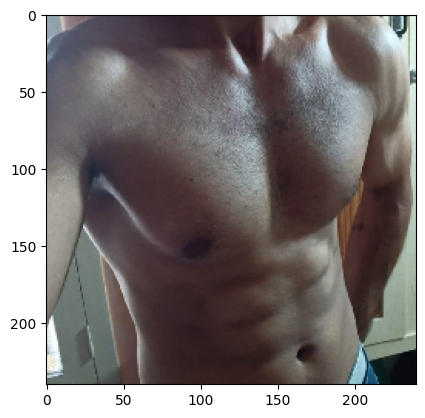

1/1 [==============================] - 0s 91ms/step
Predicted Body Fat Percentage: 13.02%
What is your age in years? 22
What is your weight in kilograms? 91
What is your height in centimeters? 191
Select your activity level:
1. Not very active
2. Moderately active
3. Very active
Enter your choice: 3
Select your goal:
1. Reduce body fat for a competition/prep
2. Put on lean muscle mass
3. Put on muscle mass as well as some body fat
4. Reduce body fat considerably e.g., from 20+ to a healthy amount
Enter your choice: 3
How many months do you want to achieve your goal in? 6
Enter any allergies you have (if none, type 'None', if you have multiple, separate them using commas): whey protein
Enter any dietary restrictions you have (if none, type 'None'): quinoa, non-veg food items 

Here is the information you entered:
Age: 22 years
Weight: 91 kg
Height: 191 cm
Activity Level: Very active
Goal: Put on muscle mass as well as some body fat
Duration: 6 months
Allergies: whey protein
Dietary Rest

In [ ]:
img_path = '/content/drive/MyDrive/test/WhatsApp Image 2024-05-08 at 01.23.28.jpeg'
img = image.load_img(img_path, target_size=(240, 240))
plt.imshow(img)
plt.show()

X = image.img_to_array(img)
X = np.expand_dims(X, axis=0)
X /= 255.0
val = model.predict(X)
predicted_class = np.argmax(val)
val
#{'16-20': 0, '20+': 1, '6-15': 2}
predicted_bf = predict_body_fat(val)
print(f"Predicted Body Fat Percentage: {predicted_bf:.2f}%")

def get_integer_input(prompt):
    """
    Utility function to handle integer inputs with validation.
    """
    while True:
        try:
            return int(input(prompt))
        except ValueError:
            print("Invalid input. Please enter a valid integer.")

def get_selection_input(prompt, choices):
    """
    Utility function to handle selection from a list with validation.
    """
    while True:
        print(prompt)
        for i, choice in enumerate(choices, 1):
            print(f"{i}. {choice}")
        try:
            selection = get_integer_input("Enter your choice: ")
            if 1 <= selection <= len(choices):
                return choices[selection - 1]
            else:
                print("Invalid choice, please try again.")
        except ValueError:
            print("Please enter a number corresponding to the choices.")

def get_user_input():
    # User inputs for age
    age = get_integer_input("What is your age in years? ")

    # User inputs for weight
    weight = get_integer_input("What is your weight in kilograms? ")

    # User inputs for height
    height = get_integer_input("What is your height in centimeters? ")

    # Menu for selecting activity level
    activity_levels = ["Not very active", "Moderately active", "Very active"]
    activity_level = get_selection_input("Select your activity level:", activity_levels)

    # Menu for selecting goal
    goals = ["Reduce body fat for a competition/prep",
             "Put on lean muscle mass",
             "Put on muscle mass as well as some body fat",
             "Reduce body fat considerably e.g., from 20+ to a healthy amount"]
    goal = get_selection_input("Select your goal:", goals)

    # User inputs for duration
    duration = get_integer_input("How many months do you want to achieve your goal in? ")

    # User inputs for allergies
    allergies = input("Enter any allergies you have (if none, type 'None', if you have multiple, separate them using commas): ")

    # User inputs for dietary restrictions
    dietary_restrictions = input("Enter any dietary restrictions you have (if none, type 'None'): ")

    return age, weight, height, activity_level, goal, duration, allergies, dietary_restrictions


age, weight, height, activity_level, goal, duration, allergies, dietary_restrictions = get_user_input()
print("\nHere is the information you entered:")
print(f"Age: {age} years")
print(f"Weight: {weight} kg")
print(f"Height: {height} cm")
print(f"Activity Level: {activity_level}")
print(f"Goal: {goal}")
print(f"Duration: {duration} months")
print(f"Allergies: {allergies}")
print(f"Dietary Restrictions: {dietary_restrictions}")



In [ ]:
API_KEY = #ENTER API KEY HERE

def generate_diet_workout(fat_percentage):
    """Generates diet and workout recommendations based on body fat percentage."""
    openai.api_key = API_KEY

    prompt = f"Given a male of age {age}, weight {weight} kg, height {height} cm and body fat percentage {fat_percentage}%, who is {activity_level}. " \
         f"generate a personalized diet plan aimed at {goal}." \
         f"Include fruits if necessary and the required water intake per day. Print the response titled " \
         f"'Here is the diet plan recommended by NutriSense360:' followed by each food item and its amount or quantity. Split the diet into an appropriate number of meals in a day according to the goal." \
         f"Consider that the user has the following allergies: {allergies}.The diet must not inlcude the following items: {dietary_restrictions}. Accordingly, include the changes in the diet. " \
         f"After all food items have been listed, calculate the exact total calorie count for the day based on the generated diet. All measurements should list both oz and grams, ml or litres where necessary. " \
         f"Consider a time of {duration} months to achieve the goal."\
         f"Print how many kgs of weight can be lost or put on after the duration(in digits)"
    print(prompt)
    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "user", "content": prompt}
        ],
        temperature=0.5
    )

    # Extract the main text from the response
    main_answer = response.choices[0].message.content.strip()
    return main_answer

fat_percentage = predicted_bf

recommendations = generate_diet_workout(fat_percentage)
print(recommendations)

Given a male of age 22, weight 91 kg, height 191 cm and body fat percentage 13.024906888604164%, who is Very active. generate a personalized diet plan aimed at Put on muscle mass as well as some body fat.Include fruits if necessary and the required water intake per day. Print the response titled 'Here is the diet plan recommended by NutriSense360:' followed by each food item and its amount or quantity. Split the diet into an appropriate number of meals in a day according to the goal.Consider that the user has the following allergies: whey protein.The diet must not inlcude the following items: quinoa, non-veg food items . Accordingly, include the changes in the diet. After all food items have been listed, calculate the exact total calorie count for the day based on the generated diet. All measurements should list both oz and grams, ml or litres where necessary. Consider a time of 6 months to achieve the goal.Print how many kgs of weight can be lost or put on after the duration(in digits